Setup the necessary objects for interacting with the database. It is assumed that create-tables was run before this file.

In [1]:
import mysql.connector as sql

con = sql.connect(host='localhost',user='root',password='ella es una bruja',db='cherokee')
cur = con.cursor()

Generate a list of the different .csv files that are in the *alignments* directory, as well as the names of the files without .csv, which will be given to the 'work' objects in the DB:

In [2]:
from os import listdir
alignments = listdir('../alignments/')
names = [a.replace('.csv','') for a in alignments]

# check for duplicate names:
if len(set(names)) != len(names):
    raise Exception('two alignments have the same name')

Create the 'work' objects in the database:

In [3]:
import pandas as pd

work_lookup = dict()
counter = 1

for name in names:
    path = f"../alignments/{name}.csv"
    work = pd.read_csv(path)
    cur.execute('INSERT INTO work (name) VALUES (%s)', (name,))
    
    for row in work.itertuples():
        cherokee = getattr(row,'chr').lstrip().rstrip()
        english = getattr(row,'en').lstrip().rstrip()
        cur.execute('INSERT INTO sentence (work_id, chr, eng) VALUES (%s,%s,%s)', (counter,cherokee,english))
    
    work_lookup[name] = (counter,work)
    counter += 1

Make a dictionary of all the cherokee words that appear in the works, mapped to their frequency:

In [4]:
import re
from collections import Counter

words = list()

for work in work_lookup.values():
    for i in work[1]['chr']:
        i = i.rstrip().lstrip()
        s = re.split('\W+', i) # split the sentence into words
        
        for x in s: # iterate over each word in the sentence
            if x == '':
                continue
        
            good = True # does the word contain only syllabary characters?
            for c in x:
                if c < 'Ꭰ' or c > 'ᏽ':
                    good = False
            
            if not good:
                continue
            else:
                words.append(x)

# count the number of times each word appears
word_counts = dict(Counter(words))
max_count = max(word_counts.values())

Populate the word table with the words extracted from the above dictionary:

In [5]:
wid = 1 # starts at one because the DB auto increment starts there too
word_id_map = dict() # a map from word to word_id for convenient insertion later.

for word in sorted(word_counts, key=lambda w: word_counts[w], reverse=True):
    cur.execute('INSERT INTO word(word,count) VALUES(%s,%s)', (word,word_counts[word]))
    word_id_map[word] = wid;
    wid += 1

In [6]:
con.commit()

Create fill-in-the-blank questions:

In [7]:
import math

sid = 0
calculated_levels = [] # used to track the frequency of different levels

for work in work_lookup.values():
    for row in work[1].itertuples():
        sid += 1
            
        sentence = getattr(row, 'chr').lstrip().rstrip()
        ws = [x for x in re.split('\W+', sentence) if x != '']
        
        # discard the sentence if there are any english words
        all_valid_words = ({w in word_id_map for w in ws}=={True})
        if not all_valid_words:
            continue

        num_spaces = 0
        for word in ws:
            wid = word_id_map[word]

            if num_spaces == 0:
                search_start = 0
            else:
                search_start = sentence.find(' ', search_start)

            word_location = sentence.find(word, search_start)

            if (word_location == -1): # goose talk crap -- don't make a question out of it.
                continue

            # the level will be defined as the square of the sentence length over the frequency of the missing word
            lvl=math.log((1/word_counts[word])*len(ws)*len(ws))
            calculated_levels.append(lvl)
            
            if lvl < -2:
                lvl=0
            elif lvl >= -2 and lvl < 3:
                lvl=1
            else:
                lvl=2
            
            cur.execute('INSERT INTO fillin(sentence_id, word_id, pos, lvl) VALUES (%s, %s, %s, %s)',
                        (sid, wid, word_location, lvl)
                        )
            num_spaces += 1

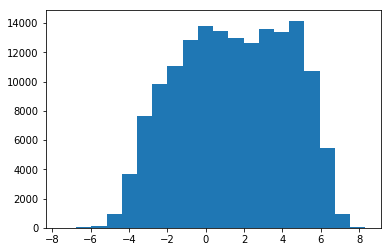

In [8]:
import matplotlib.pyplot as pt
pt.hist(x=calculated_levels,bins=20)
pt.show()

Create multiple-choice questions:

In [68]:
import random as rnd

unique_words = set(words)
cache = dict()

def find_other_choices(w):
    if w[0] not in cache:
        options = {word for word in unique_words if word[0] == w[0]}
        cache[w[0]] = options

    options = cache[w[0]] - {w}
    
    if (len(options) < 3):
        options = options.union(rnd.sample(unique_words - {w},10))
    
    return rnd.sample(options,3)


sid = 0

for work in work_lookup.values():
    for row in work[1].itertuples():
        sid += 1
        
        sentence = getattr(row, 'chr').lstrip().rstrip()
        ws = [x for x in re.split('\W+', sentence) if x != '']
        num_spaces = 0
        
        # discard the sentence if there are any english words
        all_valid_words = ({w in word_id_map for w in ws}=={True})
        if not all_valid_words:
            continue
        
        for word in ws:
            wid = word_id_map[word]

            if num_spaces == 0:
                search_start = 0
            else:
                search_start = sentence.find(' ', search_start)

            word_location = sentence.find(word, search_start)

            if (word_location == -1): # goose talk crap -- don't make a question out of it.
                continue

            others = find_other_choices(word)
            wrong1 = word_id_map[others[0]]
            wrong2 = word_id_map[others[1]]
            wrong3 = word_id_map[others[2]]

            lvl=math.log((1/word_counts[word])*len(ws)*len(ws))
            if lvl < -0.25:
                lvl=0
            elif lvl >= -0.25 and lvl < 3:
                lvl=1
            else:
                lvl=2

            #cur.execute('''INSERT INTO multiple(sentence_id,correct,wrong1,wrong2,wrong3,pos,lvl) 
             #               VALUES (%s,%s,%s,%s,%s,%s,%s)''', (sid,wid,wrong1,wrong2,wrong3,word_location,lvl)
              #            )
            num_spaces += 1

del cache
del unique_words

Write all information to the database, then close the connection:

In [8]:
con.commit()
cur.close()
con.close()